In [100]:
import cv2
import numpy as np
from math import *
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skimage.feature import hog
from skimage.feature import blob_doh, blob_dog, blob_log
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

from sklearn.pipeline import Pipeline
%matplotlib inline
%load_ext autoreload
%autoreload 1
%load_ext line_profiler

from lesson_functions import *
np.random.seed(0xdeadbeef)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [269]:
t=time.time()
cars = glob.iglob('data/vehicles/**/*.png')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcars = glob.iglob('data/non-vehicles/**/*.png')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

65.86 Seconds to extract features...


In [293]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [5]:
# np.savez_compressed('training_data.npz', X=X, y=y)

In [6]:
# with np.load('training_data.npz') as data:
#     X = data['X']
#     y = data['y']

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1000))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0xdeadbeef)

In [272]:
clf = Pipeline([('scaling', StandardScaler()),
#                 ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                ('classification', LinearSVC(loss='hinge')),
#                 ('classifier',SVC(kernel='linear'))#, probability=True))
               ])

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

11.42 Seconds to train SVC...


In [273]:
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels')

Test Accuracy of classifier =  0.9705
My classifier predicts:  [ 1.  1.  0.  0.  1.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  0.  1.  1.  0.]
0.00329 Seconds to predict 10 labels


In [294]:
from shutil import copyfile

def make_hardneg(out_path):
    y_pred = clf.predict(X)

    notcars = glob.glob('data/non-vehicles/**/*.png')
    offset = len(car_features)

    # Wrong indices
    wrong = np.nonzero(y_pred != y)[0]
    for w in wrong:
        # False positives
        if y_pred[w] == 1 and y[w] == 0:
            fname = notcars[w - offset]
            copyfile(fname, out_path+'/hardneg_'+str(w - offset)+'.png')

# make_hardneg('data/hardneg/')
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X)
conf = confusion_matrix(y, y_pred)
print(conf)

[[9669   42]
 [  67 8725]]


In [289]:
from sklearn.externals import joblib
config = dict(color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)
# joblib.dump({'model':svc, 'config':config, 'scaler':X_scaler}, 'models/model_9919.pkl')
# joblib.dump({'model':svc, 'config':config}, 'models/clf_9805.pkl')
joblib.dump({'model':clf, 'config':config}, 'models/clf_9705_hn1.pkl')

['models/clf_9705_hn1.pkl']

In [241]:
from sklearn.externals import joblib
# data = joblib.load('models/clf_9892_ycbcr.pkl')
data = joblib.load('models/clf_9737_y.pkl')
# svc = data['model']
clf = data['model']
config = data['config']
# X_scaler = data['scaler']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
print(config)

{'spatial_feat': True, 'hog_channel': 0, 'pix_per_cell': 8, 'color_space': 'YCrCb', 'cell_per_block': 2, 'hog_feat': True, 'hist_bins': 16, 'orient': 9, 'hist_feat': True, 'spatial_size': (16, 16)}


In [178]:
def create_windows(pyramid, image_size):
    output = []
    for w_size, y_lims in pyramid:
        windows = slide_window(image_size, x_start_stop=[None, None], y_start_stop=y_lims, 
                        xy_window=w_size, xy_overlap=(0.5, 0.5))
        output.extend(windows)
    return output

def multiscale_detect(image, clf, config, windows, verbose=False):
    
    color_space = config['color_space']
    spatial_size = config['spatial_size']
    hist_bins = config['hist_bins']
    orient = config['orient']
    pix_per_cell = config['pix_per_cell']
    cell_per_block = config['cell_per_block']
    hog_channel = config['hog_channel']
    spatial_feat = config['spatial_feat']
    hist_feat = config['hist_feat']
    hog_feat = config['hog_feat']
    
    hot_windows = search_windows(image, windows, clf, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Detect bounding boxes
    heatmap = np.zeros((image.shape[0],image.shape[1]), np.uint8)
    for pt1, pt2 in hot_windows:
        x1, y1 = pt1
        x2, y2 = pt2
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))
        heatmap[yv, xv] += 10
        
    _, contours, _ = cv2.findContours(heatmap, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = [cv2.boundingRect(pts) for pts in contours]
    
    return bboxes

In [192]:
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
#            ((256, 256),[400, None])
      ]
image_size = (720, 1280)
windows = create_windows(pyramid, image_size)

In [287]:
image = mpimg.imread('test_images/test6.jpg')
image = image.astype(np.float32)/255.

Detected 3 vehicles in 0.36 seconds


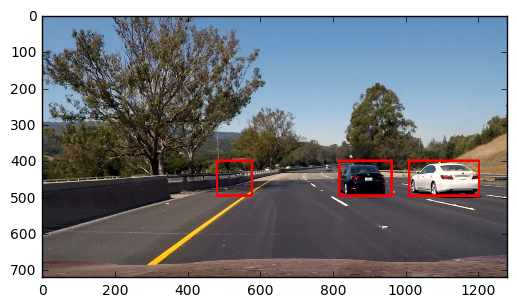

In [288]:
# %lprun -f single_img_features multiscale_detect(image, clf, config, windows)
t = time.time()
bboxes = multiscale_detect(image, clf, config, windows)
t2 = time.time() - t 
print('Detected %d vehicles in %.2f seconds' % (len(bboxes), t2))

# compute_positions(hot_windows, image_size)
im2 = (np.copy(image)*255).astype(np.uint8)
for x_,y_,w_,h_ in bboxes:
    cv2.rectangle(im2,(x_,y_),(x_+w,y_+h),color=(255,0,0),thickness=6)
plt.imshow(im2)

plt.show()